#LAB 9: Stable diffusion customizing_tutorial


### **Required Package**
- accelerate version: 0.26.1
- datasets==2.16.1
- diffusers version: 0.26.0.dev0
- invisible-watermark version: 0.2.0
- numpy version: 1.26.3
- omegaconf version: 2.3.0
- opencv-python version: 4.9.0.80
- peft==0.7.1
- scipy version: 1.12.0
- torch version: 2.1.2
- torchvision version: 0.16.2
- transformers version: 4.37.0

### **Reference**
- Diffusers Official Document  [homepage](https://huggingface.co/docs/diffusers/main/en/index)  
- Datasets Official Document  [homepage](https://huggingface.co/docs/datasets/index)
- segmind blog [blog](https://blog.segmind.com/prompt-guide-for-stable-diffusion-xl-crafting-textual-descriptions-for-image-generation/)

### **필요 패키지 import**

In [1]:
! pip install -q -U \
    datasets \
    peft \
    diffusers \
    bing-image-downloader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Standard library imports
import math
import os
import random

# Third-party imports
import numpy as np
import pandas
import glob
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from PIL import Image
from accelerate import Accelerator
from accelerate.logging import get_logger
from datasets import load_dataset
from bing_image_downloader import downloader
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from tqdm.auto import tqdm
from torchvision import transforms
from transformers import (
    AutoTokenizer,
    PretrainedConfig,
    BlipProcessor,
    BlipForConditionalGeneration,
)

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
    StableVideoDiffusionPipeline,
    StableDiffusionPipeline
)
from diffusers.loaders import LoraLoaderMixin
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params
from diffusers.utils import (
    make_image_grid,
    convert_state_dict_to_diffusers,
    export_to_video,
    export_to_gif,
)
from diffusers.utils.torch_utils import is_compiled_module

# 1. Custom Dataset 정의

StableDiffusion과 같은 diffusers에서 지원하는 Diffusion 모델들은 Huggingface에서 지원하는 accelerate, datasets, transformers 와 같은 패키지들과 호환되도록 구현되어 있습니다.
LoRA 학습을 위해서는 Huggingface에서 지원하는 datasets 패키지를 이용하여 Custom Dataset을 정의해야 합니다.


## 1-1. Folder 구조 만들기

In [3]:
custom_dataset_folder_name = "gen_ai_custom_dataset"
if not os.path.exists(custom_dataset_folder_name):
    os.makedirs(custom_dataset_folder_name)
if not os.path.exists(os.path.join(custom_dataset_folder_name, "train")):
    os.makedirs(os.path.join(custom_dataset_folder_name, "train"))
custom_dataset_folder_path = os.path.join(os.getcwd(), custom_dataset_folder_name)

폴더의 구조는 다음과 같이 구성되어 있어야 합니다.
    
    folder/train/dog/golden_retriever.png
    folder/train/cat/maine_coon.png
    folder/test/dog/german_shepherd.png
    folder/test/cat/bengal.png

## 1-2. Image 크롤링

LoRA 학습에 가장 중요한 image들을 모아야합니다.  
원하는 image들을 쉽게 모으기 위해서는
이번 실습에서는 bing 에서 open license image들을 크롤링 하여 사용하였습니다.

In [4]:
query = "8 bit illustration"
downloader.download(
    query,
    limit=100,
    output_dir=custom_dataset_folder_path,
    adult_filter_off=True,
    force_replace=False,
    timeout=60,
    verbose=False,
)


[%] Downloading Images to /content/gen_ai_custom_dataset/8 bit illustration
[!] Issue getting: https://i1.wp.com/plainmagazine.com/wp-content/uploads/2017/05/content_plain-magazine-adam-lister-05.jpg?ssl=1
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://static.vecteezy.com/system/resources/previews/024/542/163/original/landscape-8bit-pixel-art-summer-natural-landscape-mountain-scenery-arcade-video-game-background-vector.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://static.vecteezy.com/system/resources/previews/025/560/519/original/crown-pixel-8-bit-isolated-on-white-background-free-vector.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://static.vecteezy.com/system/resources/previews/011/458/147/non_2x/8-bit-pixels-hero-avatar-game-character-in-illustration-vector.jpg
[!] Error:: HTTP Error 403: Forbidden
[Error]Invalid image, not saving https://wallpapers.com/images/hd/8-bit-background-00eolrvv0ccowrjf.jpg

[!] Issue getting: h

In [5]:
# 파일 이름 변경
for idx, item in enumerate(
    os.listdir(
        os.path.join(
            custom_dataset_folder_path,
            query,
        )
    )
):
    format = item.split(".")[-1]
    # idx format 0 -> 00
    idx = str(idx).zfill(2)
    os.rename(
        os.path.join(custom_dataset_folder_path, query, item),
        os.path.join(custom_dataset_folder_path, "train", f"{idx}.{format}"),
    )

# 1-3. Captioning

LoRA 학습을 위해서는 이미지와 함께 이미지에 대한 설명을 포함하는 caption이 필요합니다. 이를 위해서는 이미지에 대한 caption을 생성해야 합니다. 이번 예제에서는 이미지에 대한 caption을 생성하기 위해서 이미지 캡셔닝 모델 BLIP을 사용합니다.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base", torch_dtype=torch.float16
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

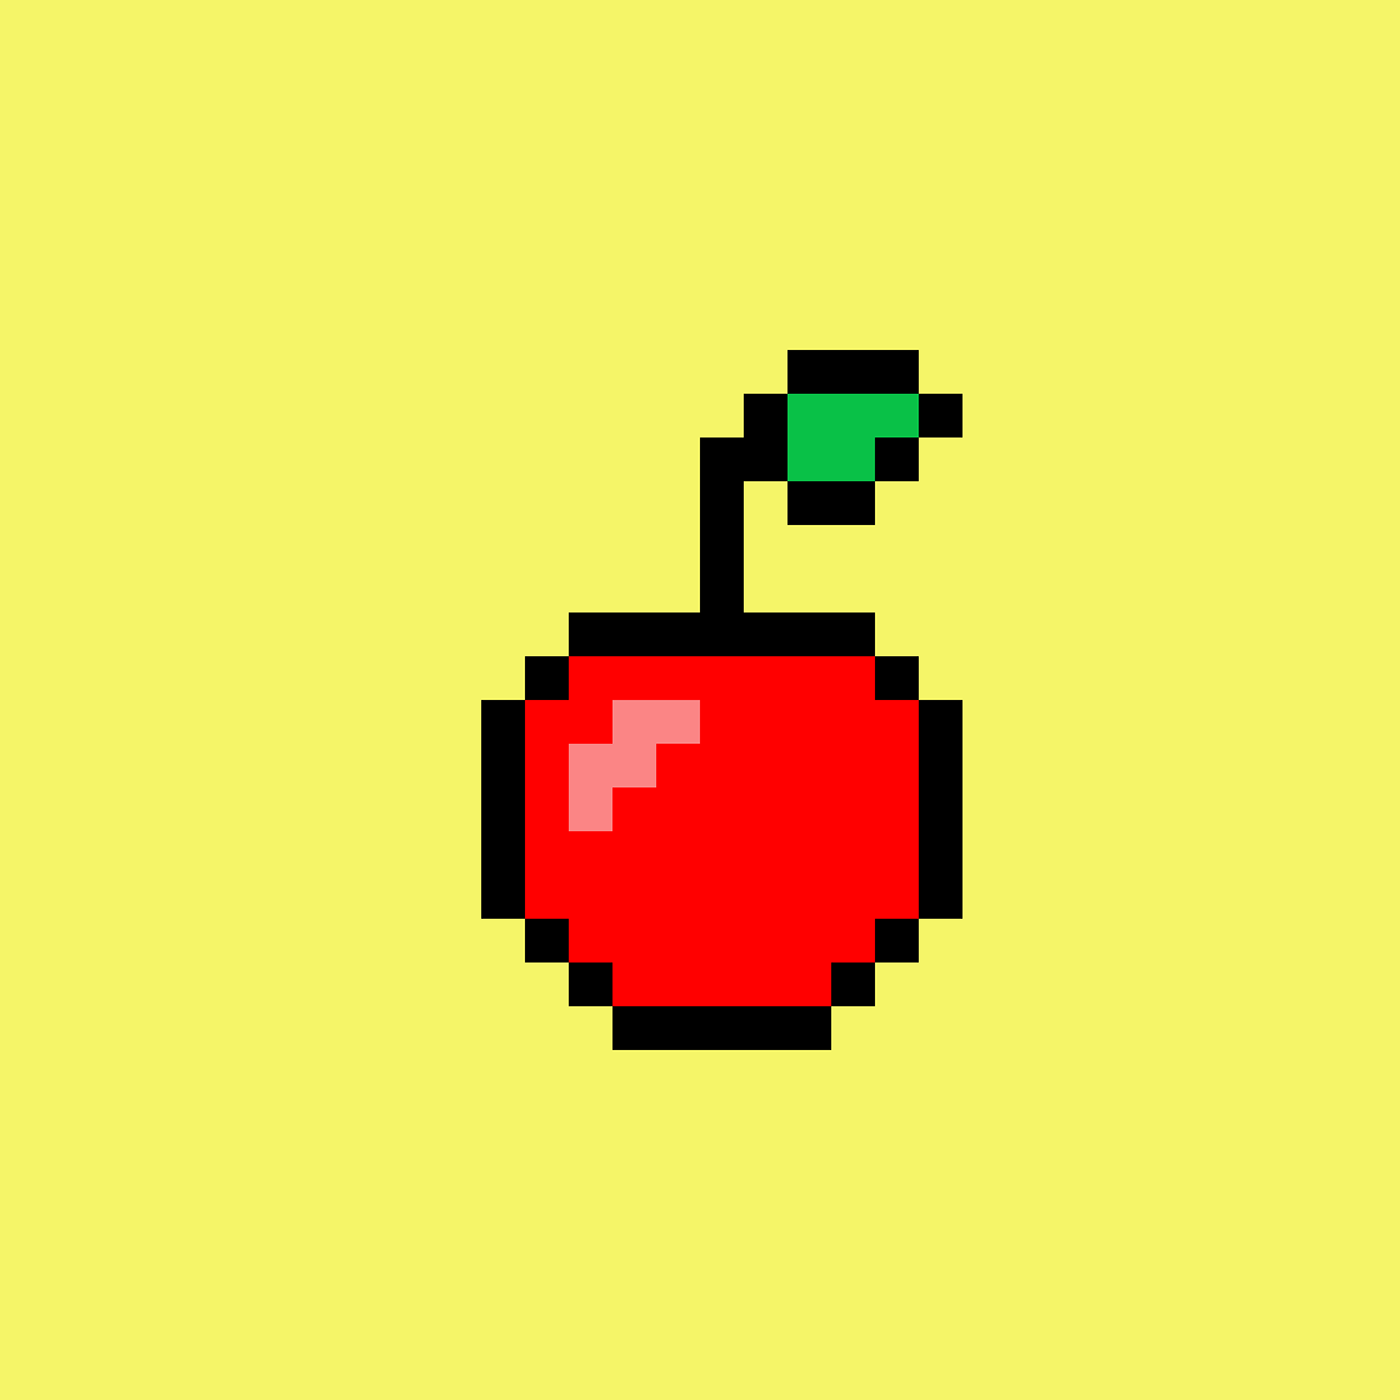

In [7]:
test_image = Image.open(next(iter(glob.glob(os.path.join(custom_dataset_folder_path, "train", "87*"))), None))
test_image

In [8]:
inputs = processor(test_image, return_tensors="pt").to(device, torch.float16)
out = model.generate(**inputs, max_new_tokens=50)
print(processor.decode(out[0], skip_special_tokens=True))

an apple is shown in the middle of the image


## 1-5. Metadata.csv 작성하기

이러한 Caption들을 지정된 format에 맞추어 csv 혹은 json 포맷으로 저장해야합니다.  
csv 포맷이라 하면 아래와 같이  

    file_name,additional_feature
    0001.png,This is a first value of a text feature you added to your images
    0002.png,This is a second value of a text feature you added to your images
    0003.png,This is a third value of a text feature you added to your images

json 포맷이라 하면  

    {"file_name": "0001.png", "additional_feature": "This is a first value of a text feature you added to your images"}
    {"file_name": "0002.png", "additional_feature": "This is a second value of a text feature you added to your images"}
    {"file_name": "0003.png", "additional_feature": "This is a third value of a text feature you added to your images"}

와 같이 작성해야합니다.




이를 위해 pandas dataframe을 이용하여 caption을 저장합니다.


In [9]:
metadata = pandas.DataFrame(columns=["file_name", "caption"])

In [10]:
for idx, item in enumerate(
    os.listdir(os.path.join(custom_dataset_folder_path, "train"))
):
    format = item.split(".")[-1]
    image_path = os.path.join(custom_dataset_folder_path, "train", item)
    test_image = Image.open(image_path)
    inputs = processor(test_image, return_tensors="pt").to(device, torch.float16)
    out = model.generate(**inputs, max_new_tokens=50)
    caption = processor.decode(out[0], skip_special_tokens=True)
    metadata.loc[idx] = [item, caption]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
# sort by Image column
metadata = metadata.sort_values(by=["file_name"]).reset_index(drop=True)
metadata.head(5)

,file_name,caption
0,00.png,a pixel pixel pixel pixel pixel pixel pixel pi...
1,01.jpg,a pixel pixel pixel pixel pixel pixel pixel pi...
2,02.jpg,pixel font with pixel effect pixel font with p...
3,03.png,a pixel pixel pixel pixel pixel pixel pixel pi...
4,04.gif,a bed in a room with a window


In [12]:
# save metadata
metadata.to_csv(
    os.path.join(custom_dataset_folder_path, "train", "metadata.csv"), index=False
)

최종 폴더구조는 아래와 같이 이루어지게 됩니다
<pre><code>
├── gen_ai_custom_dataset
│   └── train
│   │    └── metadata.csv
│   │    └── 00.jpg
...
</code></pre>

## 1-6. Dataset 정의

위와 같은 과정이 마무리 된다면, 이제 customdataset을 정의할 수 있습니다.

In [13]:
custom_dataset = load_dataset("imagefolder", data_dir=custom_dataset_folder_path)

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
custom_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=880x626>,
 'caption': 'a pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel pixel'}

## 2. LoRA 학습

LoRA 학습의 경우 앞 6강 실습-1 에서 사용한 코드를 그대로 사용합니다.

In [15]:
del model
torch.cuda.empty_cache()

#### Prompt Tokenization 을 위한 함수 선언

In [16]:
def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
)
    text_input_ids = text_inputs.input_ids
    return text_input_ids


# Adapted from pipelines.StableDiffusionXLPipeline.encode_prompt
def encode_prompt(text_encoders, tokenizers, prompt, text_input_ids_list=None):
    prompt_embeds_list = []

    for i, text_encoder in enumerate(text_encoders):
        if tokenizers is not None:
            tokenizer = tokenizers[i]
            text_input_ids = tokenize_prompt(tokenizer, prompt)
        else:
            assert text_input_ids_list is not None
            try:
                text_input_ids = text_input_ids_list[i]
            except IndexError:
                pass
            #text_input_ids = text_input_ids_list[i]

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
            return_dict=False,
    )

        # We are only ALWAYS interested in the pooled output of the final text encoder
        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds[-1][-2]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds

def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder
)
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel(text_encoder_config).from_pretrained(
            pretrained_model_name_or_path, subfolder=subfolder
        )
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection(text_encoder_config).from_pretrained(
            pretrained_model_name_or_path, subfolder=subfolder
        )
    else:
        raise ValueError(f"{model_class} is not supported.")

### StableDiffusion을 구성하는 세부 모델들 선언

#### Pretrained Model 및 기타 config 선언
학습에 사용될 pretrained model은 "runwayml/stable-diffusion-v1-5" 을 이용합니다.  
빠른 학습을 위해 Floating Point Precision (부동소수점) 은 16 FP16 을 사용합니다.

In [17]:
MODEL_NAME  = "runwayml/stable-diffusion-v1-5"
VAE_NAME ="stabilityai/sd-vae-ft-mse"
VARIANT = "fp16"

#### Pretrained Model 및 기타 config 선언
#### **다음은 StableDiffusionXL을 사용하여 이미지를 생성하는 예시입니다.**  
학습에 사용될 pretrained model은 "stabilityai/stable-diffusion-xl-base-1.0" 을 이용합니다.  

빠른 학습을 위해 Floating Point Precision (부동소수점) 은 16 FP16 을 사용합니다.  
다만 FP16으로 학습을 진행하는 경우 현재 "stabilityai/stable-diffusion-xl-base-1.0"의 VAE에 오류가 있어, VAE는 "madebyollin/sdxl-vae-fp16-fix"를 사용합니다.

In [18]:
MODEL_NAME  = "stabilityai/stable-diffusion-xl-base-1.0"
VAE_NAME ="madebyollin/sdxl-vae-fp16-fix"
VARIANT = "fp16"

#### Tokenizer, Text Encoder 선언

In [19]:
tokenizer_one = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path = MODEL_NAME,
        subfolder = "tokenizer",
        use_fast = False,
)
text_encoder_one = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path = MODEL_NAME,
        subfolder = "text_encoder",
)

tokenizer_two =  None
text_encoder_two = None

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

In [20]:
# StableDiffusionXL의 경우 두개의 Text Encoder를 사용하여 두개의 Tokenizer를 불러옵니다.
tokenizer_two = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path = MODEL_NAME,
        subfolder = "tokenizer_2",
        use_fast = False,
)


text_encoder_two = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path = MODEL_NAME,
        subfolder = "text_encoder_2",
)

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

#### Noise Scheduler, VAE, UNET 선언

In [21]:
noise_scheduler = DDPMScheduler.from_pretrained(
        pretrained_model_name_or_path = MODEL_NAME,
        subfolder = "scheduler"
)

vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path = VAE_NAME,
)

unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path = MODEL_NAME,
        subfolder = "unet",
        variant = VARIANT,
)

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

추가된 adapter LoRA 레이어들만 학습 시키기 때문 나머지 함수들은 requires_grad_(False)로 설정해줍니다.

In [22]:
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
unet.requires_grad_(False)
print("VAE, Text Encoder, and UNet are frozen.")

VAE, Text Encoder, and UNet are frozen.


In [23]:
# StableDiffusionXL의 경우 두개의 Text Encoder를 사용하여 두개의 Tokenizer를 불러옵니다.
text_encoder_two.requires_grad_(False)

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1280)
      (position_embedding): Embedding(77, 1280)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (layer_norm2)

### 학습 루프 함수 정의

In [24]:
seed = 2015
train_batch_size = 2
resolution = 1024
max_train_steps = 10000
checkpointing_steps = 5000
learning_rate = 1e-4
output_dir = "./sd_lora"

# Make sure output_dir exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [25]:
logger = get_logger(__name__)

def training_function(dataset, unet, vae, text_encoder_one, text_encoder_two=None):

    # Init Accelerator
    accelerator = Accelerator(mixed_precision=VARIANT)
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # 세부 모델들 GPU로 올리기, 및 datatype 설정
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder_one.to(accelerator.device, dtype=weight_dtype)
    if text_encoder_two is not None:
        text_encoder_two.to(accelerator.device, dtype=weight_dtype)

    # LoRA config 설정
    # UNet의 Attention Layer에 LoRA weights를 추가
    # Set correct lora layers
    unet_lora_config = LoraConfig(
        r=4, # Dimension of LoRA update Matrices
        lora_alpha=4, # Dimension of LoRA update Matrices
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    unet.add_adapter(unet_lora_config)

    # Trainable Parameter (LoRA weights) 만을 FP32로 Upcast
    cast_training_params([unet], dtype=torch.float32)

    # Accelerator에 wrap된 모델을 unwrap하는 내부함수
    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model


    # Custom 된  save & loading hook 함수. LoRA Weight만을 저장하고 불러오는 용도로 사용
    # 실질적으로 accelrator.save_state() 함수 사용을 위해 필요한 함수
    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            # there are only two options here. Either are just the unet attn processor layers
            # or there are the unet and text encoder atten layers
            unet_lora_layers_to_save = None
            text_encoder_one_lora_layers_to_save = None
            if text_encoder_two is not None:
                text_encoder_two_lora_layers_to_save = None

            for model in models:
                if isinstance(unwrap_model(model), type(unwrap_model(unet))):
                    unet_lora_layers_to_save = convert_state_dict_to_diffusers(
                        get_peft_model_state_dict(model)
                    )
                elif isinstance(
                    unwrap_model(model), type(unwrap_model(text_encoder_one))
                ):
                    text_encoder_one_lora_layers_to_save = (
                        convert_state_dict_to_diffusers(
                            get_peft_model_state_dict(model)
                        )
                    )
                elif isinstance(
                    unwrap_model(model), type(unwrap_model(text_encoder_two))
                ):
                    text_encoder_two_lora_layers_to_save = (
                        convert_state_dict_to_diffusers(
                            get_peft_model_state_dict(model)
                        )
                    )
                else:
                    raise ValueError(f"unexpected save model: {model.__class__}")

                # make sure to pop weight so that corresponding model is not saved again
                if weights:
                    weights.pop()

            if text_encoder_two is not None:
                StableDiffusionXLPipeline.save_lora_weights(
                    output_dir,
                    unet_lora_layers=unet_lora_layers_to_save,
                    text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
                    text_encoder_2_lora_layers=text_encoder_two_lora_layers_to_save,
                )
            else:
                StableDiffsuionPipeline.save_lora_weights(
                    output_dir,
                    unet_lora_layers=unet_lora_layers_to_save,
                    text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
                )

    def load_model_hook(models, input_dir):
        unet_ = None
        text_encoder_one_ = None
        text_encoder_two_ = None

        while len(models) > 0:
            model = models.pop()

            if isinstance(model, type(unwrap_model(unet))):
                unet_ = model
            elif isinstance(model, type(unwrap_model(text_encoder_one))):
                text_encoder_one_ = model
            elif isinstance(model, type(unwrap_model(text_encoder_two))):
                text_encoder_two_ = model
            else:
                raise ValueError(f"unexpected save model: {model.__class__}")

        lora_state_dict, network_alphas = LoraLoaderMixin.lora_state_dict(input_dir)
        LoraLoaderMixin.load_lora_into_unet(
            lora_state_dict, network_alphas=network_alphas, unet=unet_
        )

        text_encoder_state_dict = {
            k: v for k, v in lora_state_dict.items() if "text_encoder." in k
        }
        LoraLoaderMixin.load_lora_into_text_encoder(
            text_encoder_state_dict,
            network_alphas=network_alphas,
            text_encoder=text_encoder_one_,
        )
        if text_encoder_two_ is not None:
            text_encoder_2_state_dict = {
                k: v for k, v in lora_state_dict.items() if "text_encoder_2." in k
            }
            LoraLoaderMixin.load_lora_into_text_encoder(
                text_encoder_2_state_dict,
                network_alphas = network_alphas,
                text_encoder = text_encoder_two_,
            )

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

    # Optimizer 설정
    optimizer_class = torch.optim.AdamW
    # Optimizer creation
    params_to_optimize = list(filter(lambda p: p.requires_grad, unet.parameters()))
    optimizer = optimizer_class(
        params_to_optimize,
        lr=learning_rate*train_batch_size,
        betas = (0.9, 0.999),
        weight_decay = 1e-2,
        eps = 1e-08,
    )

    # Preprocessing the datasets
    # 먼저 데이터셋의 Column 구분 (Image, Caption)
    column_names = dataset["train"].column_names
    image_column = column_names[0]
    caption_column = column_names[1]

   # Captipon 들을 두가지 Text Tokenizer로 Tokenize 하는 내부함수 정의
    def tokenize_captions(examples, is_train=True,):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        tokens_one = tokenize_prompt(tokenizer_one, captions)
        if text_encoder_two is not None:
            tokens_two = tokenize_prompt(tokenizer_two, captions)
        else:
            tokens_two = None
        return tokens_one, tokens_two

    # Image 를 전처리 하는 부분 정의
    train_resize = transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR)
    train_crop = transforms.CenterCrop(resolution)
    train_flip = transforms.RandomHorizontalFlip(p=1.0)
    train_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    # Image 와 Caption preprocessing 을 위한 종합 내부함수정의
    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        # image aug
        original_sizes = []
        all_images = []
        crop_top_lefts = []
        for image in images:
            original_sizes.append((image.height, image.width))
            image = train_resize(image)
            if random.random() < 0.5:# flip
                image = train_flip(image)
            y1 = max(0, int(round((image.height - resolution) / 2.0)))
            x1 = max(0, int(round((image.width - resolution) / 2.0)))
            image = train_crop(image)
            crop_top_left = (y1, x1)
            crop_top_lefts.append(crop_top_left)
            image = train_transforms(image)
            all_images.append(image)

        examples["original_sizes"] = original_sizes
        examples["crop_top_lefts"] = crop_top_lefts
        examples["pixel_values"] = all_images
        tokens_one, tokens_two = tokenize_captions(examples)
        examples["input_ids_one"] = tokens_one
        if text_encoder_two is not None:
            examples["input_ids_two"] = tokens_two
        return examples

    # Training Dataset 생성
    train_dataset = dataset["train"].with_transform(preprocess_train)

    # DataLoader 생성
    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        original_sizes = [example["original_sizes"] for example in examples]
        crop_top_lefts = [example["crop_top_lefts"] for example in examples]
        input_ids_one = torch.stack([example["input_ids_one"] for example in examples])
        if text_encoder_two is not None:
            input_ids_two = torch.stack([example["input_ids_two"] for example in examples])
            return {
                "pixel_values": pixel_values,
                "input_ids_one": input_ids_one,
                "input_ids_two": input_ids_two,
                "original_sizes": original_sizes,
                "crop_top_lefts": crop_top_lefts,
            }
        else:
            return {
                "pixel_values": pixel_values,
                "input_ids_one": input_ids_one,
                "original_sizes": original_sizes,
                "crop_top_lefts": crop_top_lefts,
            }
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle = True,
        collate_fn = collate_fn,
        batch_size = train_batch_size,
        num_workers = 0,
    )

    lr_scheduler = get_scheduler(
        'cosine',
        optimizer=optimizer,
        num_warmup_steps = 500 * 1,
        num_training_steps = max_train_steps *1,
    )

    # Prepare with  accelerator
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(unet, optimizer, train_dataloader, lr_scheduler)


    # Training 시작 전 기본 세팅
    num_train_epochs = math.ceil(max_train_steps / len(train_dataset))
    total_batch_size = train_batch_size * accelerator.num_processes
    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    global_step = 0
    first_epoch = 0
    initial_global_step = 0

    progress_bar = tqdm(
        range(0, max_train_steps),
        initial = initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable = not accelerator.is_local_main_process,
    )

    # Training Loop 시작
    for epoch in range(first_epoch, num_train_epochs):
        unet.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                pixel_values = batch["pixel_values"].to(dtype=weight_dtype)
                model_input = vae.encode(pixel_values).latent_dist.sample()
                model_input = model_input * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(model_input)

                bsz = model_input.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=model_input.device,
                )
                timesteps = timesteps.long()

                # Add noise to the model input according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

                # time ids
                def compute_time_ids(original_size, crops_coords_top_left):
                    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
                    target_size = (resolution, resolution)
                    add_time_ids = list(original_size + crops_coords_top_left + target_size)
                    add_time_ids = torch.tensor([add_time_ids])
                    add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
                    return add_time_ids

                add_time_ids = torch.cat(
                    [
                        compute_time_ids(s, c)
                        for s, c in zip(
                            batch["original_sizes"], batch["crop_top_lefts"]
                        )
                    ]
                )

                # Predict the noise residual
                unet_added_conditions = {"time_ids": add_time_ids}

                if text_encoder_two is not None:
                    text_input_ids_list = [
                        batch["input_ids_one"],
                        batch["input_ids_two"],
                    ]
                    prompt_embeds, pooled_prompt_embeds = encode_prompt(
                        text_encoders=[text_encoder_one, text_encoder_two],
                        tokenizers=None,
                        prompt=None,
                        text_input_ids_list=text_input_ids_list,
                    )
                else:
                    text_input_ids_list = [batch["input_ids_one"]]

                    prompt_embeds, pooled_prompt_embeds = encode_prompt(
                        text_encoders=[text_encoder_one],
                        tokenizers=None,
                        prompt=None,
                        text_input_ids_list=text_input_ids_list,
                    )
                unet_added_conditions.update({"text_embeds": pooled_prompt_embeds})
                model_pred = unet(
                    noisy_model_input,
                    timesteps,
                    prompt_embeds,
                    added_cond_kwargs=unet_added_conditions,
                    return_dict=False,
                )[0]


                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(model_input, noise, timesteps)
                else:
                    raise ValueError(
                        f"Unknown prediction type {noise_scheduler.config.prediction_type}"
                    )

                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(train_batch_size)).mean()
                train_loss += avg_loss.item()

                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(params_to_optimize, 1)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if accelerator.is_main_process:
                    if global_step % checkpointing_steps == 0:
                        save_path = os.path.join(
                            output_dir, f"checkpoint-{global_step}"
                        )
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {
                "step_loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break
    # Training 종료
    # Save the lora layers
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unwrap_model(unet)
        unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))
        StableDiffusionXLPipeline.save_lora_weights(
            save_directory=output_dir,
            unet_lora_layers=unet_lora_state_dict,
        )
        del unet
        torch.cuda.empty_cache()

In [26]:
import accelerate

accelerate.notebook_launcher(training_function, args=(custom_dataset, unet, vae, text_encoder_one, text_encoder_two), num_processes=0)

Launching training on one GPU.


Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Load 학습된 LoRA

In [35]:
pipeline_repo_id = "stabilityai/stable-diffusion-xl-base-1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = StableDiffusionXLPipeline.from_pretrained(
                                                pretrained_model_name_or_path = pipeline_repo_id,
                                                torch_dtype = torch.float16,
                                                variant = "fp16",
                                                use_safetensors = True,
                                                ).to(device)

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [34]:
# state_dict = torch.load("./sd_lora/checkpoint-5000/optimizer.bin")
# print(state_dict.keys())

<ipython-input-34-6cb346558325>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./sd_lora/checkpoint-5000/optimizer.bin")


dict_keys(['state', 'param_groups'])


In [36]:
pipeline.load_lora_weights("./sd_lora")

# state_dict = torch.load("./sd_lora/pytorch_lora_weights.safetensors.bin")
# pipeline.unet.load_state_dict(state_dict, strict=False)

In [39]:
inference_prompt = "8bit illustration of city view"
# inference_prompt = "16bit illustration of apple"
images = pipeline(inference_prompt, num_images_per_prompt=3).images
make_image_grid(images, rows=1, cols=3)


Output hidden; open in https://colab.research.google.com to view.

학습된 LoRA weight 이외에도, Huggingface hub에 올라와 있는 다양한 LoRA 모델들을 불러올 수 있습니다.

아래의 예시들은 Stable Diffusion XL 모델을 불러오는 예시입니다.
Colab 환경 아래에서는 실행이 불가할 수 있으니 참고 바랍니다.


In [ ]:
pipeline_repo_id = "stabilityai/stable-diffusion-xl-base-1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = StableDiffusionXLPipeline.from_pretrained(
                                                pretrained_model_name_or_path = pipeline_repo_id,
                                                torch_dtype = torch.float16,
                                                variant = "fp16",
                                                use_safetensors = True,
                                                ).to(device)

pipeline.unload_lora_weights()
pipeline.load_lora_weights("nerijs/lego-minifig-xl")


In [ ]:
inference_prompt = "lego minifig of a kpop idol"
images = pipeline(inference_prompt, num_images_per_prompt=3).images
make_image_grid(images, rows=1, cols=3)


In [ ]:
pipeline.unload_lora_weights()
pipeline.load_lora_weights("goofyai/3d_render_style_xl")

In [ ]:
inference_prompt = "3d style of a man with a hat"
images = pipeline(inference_prompt, num_images_per_prompt=3).images
make_image_grid(images, rows=1, cols=3)

동시에 여러개의 LoRA 모델 또한 Fuse하여 사용할 수 있습니다.
각각의 LoRA weight들을 불러와 adapter_name을 지정한 후 불러올 수도 있습니다.

In [ ]:
pipeline.unload_lora_weights()
pipeline.load_lora_weights("TheLastBen/Papercut_SDXL", adapter_name="paper_cut")
pipeline.load_lora_weights("nerijs/pixel-art-xl", adapter_name="pixel_art")
print("Weights loaded")

In [ ]:
pipeline.set_adapters(["paper_cut", "pixel_art"], adapter_weights=[0.5, 1.0])

In [ ]:
inference_prompt = "A cute hedgehog plushie with a brown back and yellow face with black eyes, pixel art, paper cut"
images = pipeline(inference_prompt, num_images_per_prompt=3).images
make_image_grid(images, rows=1, cols=3)

Huggingface 에 올라와있는 다양한 LoRA Weight들은 아래의 링크에서 확인해보실 수 있습니다.  
https://huggingface.co/models?other=base_model:stabilityai/stable-diffusion-xl-base-1.0


# 2. Prompting Tips

자연스러운 이미지 생성을 위해서는 좋은 모델을 사용하는 것도 중요하지만, 좋은 모델을 사용하더라도 좋은 prompt를 사용하지 않는다면 원하는 이미지를 생성하기 어렵습니다.
다음은 prompt를 사용하는 방법과 다른 parameter들을 조정하여 원하는 이미지를 만들 수 있는에 대한 간단한 설명입니다.

In [ ]:
del pipeline
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    variant="fp16",
    torch_dtype=torch.float16,
)

pipeline = pipeline.to(device)
print("pipeline loaded")

### 좋은 Prompt의 구성 요소

Prompt는 인공지능 모델이 원하는 이미지를 생성하도록 유도하는 핵심 문장입니다. **효과적인 Prompt**는 모델이 명확하고 상세하게 원하는 이미지를 이해하도록 도와줍니다. 그렇다면, 어떤 요소들이 좋은 Prompt를 구성하는지 알아보겠습니다.   

---

#### 1. 주제 (**Subject**)
좋은 Prompt의 핵심은 생성할 이미지의 주제, 즉 **Subject**입니다. Subject는 Prompt의 중심이 되는 객체로, 다음 네 가지 주요 요소를 포함해야 합니다.

##### a. 대상 (**Character**)
- **Character**는 이미지의 주인공이 됩니다. 이는 사람, 동물, 또는 다른 어떤 캐릭터일 수 있습니다.

##### b. 행위 (**Action**)
- **Action**은 Character가 수행하는 동작이나 활동을 나타냅니다. 이는 이미지에 동적인 요소를 더해줍니다.

##### c. 장소 (**Location**)
- **Location**은 Action이 일어나는 배경이 됩니다. 이는 이미지에 공간적 맥락을 제공합니다.

##### d. 감정 (**emotion**)
- **emotion**은 Character의 감정을 나타냅니다. 이는 이미지에 감정적인 요소를 더해줍니다.

Prompt 작성 시 이러한 요소들을 구체적으로 명시함으로써, AI가 보다 정확하고 생생한 이미지를 생성할 수 있도록 유도할 수 있습니다.


In [ ]:
# prompt that only contain simple text
simple_prompt = "A man with a hat"
simple_image = pipeline(simple_prompt, num_images_per_prompt=1).images[0]

# prompt that contain character, action, location, and emotion
advanced_prompt_1 = (
    "A man with a hat sitting on a bench in a bustling city park, looking contemplative"
)
advanced_image_1 = pipeline(advanced_prompt_1, num_images_per_prompt=1).images[0]

make_image_grid([simple_image, advanced_image_1], rows=1, cols=2)

#### 2. Depth, Nuance
주제에 대한 설명을 추가했으면 이미지에 깊이와 풍부함을 더하는 구체적인 사항들을 추가해야합니다.

##### a. 색상 (**Color**)
- **Color**는 이미지의 색상을 나타냅니다. 이는 이미지에 시각적인 요소를 더해줍니다. 생동감 있는 이미지 혹은 파스텔 톤?, 다양한 색상의 이미지를 생성하고 싶다면 이를 추가해보세요.

##### b. 질감 (**Texture**)
- **Texture**는 이미지의 질감을 나타냅니다. 비단의 부드러움, 나무의 거침, 또는 물체의 광택과 같은 질감을 추가할 수 있습니다.

##### c. 상대적 크기 (**Proportions**)
- **Proportions**는 이미지 내의 물체들의 상대적인 크기를 나타냅니다. 이는 이미지에 공간적 맥락을 제공하여 조화와 균형을 더해줍니다.

##### d. 관점 (**Perspective**)
- **Perspective**는 장면이 펼쳐지는 방식을 결정하는 관점으로, 위에서 내려다보는이 될 수도 있고, 옆에서 몰래 보는 관점이 될 수도 있습니다.

##### e. 빛과 그림자 (**Reflections and Shadows**)
- **Reflections and Shadows**는 빛과 그림자를 나타냅니다. 이는 이미지의 현실감과 깊이, 차원을 더해줍니다.

In [ ]:
# prompt that contain Color, Texture, proportions, perspective, and lightings
advanced_prompt_2 = "A man with a hat sitting on a bench in a bustling city park, looking contemplative, pastel tone color, rough texture, close up, low angle, low contrast"
advanced_image_2 = pipeline(advanced_prompt_2, num_images_per_prompt=1).images[0]

make_image_grid([simple_image, advanced_image_1, advanced_image_2], rows=1, cols=3)

#### 3. Artistic Style
그림의 스타일 추가하는 요소를 포함하면 그림을 더 완성도 있게 만들 수 있습니다.
***Artistic Style*** 이라 하면 다음과 같을 수 있습니다.
- Comic Book, Watercolor, Oil Painting, Pencil Sketch, Pointillism, Impressionism, Cubism, Surrealism, Expressionism, Pop Art, Minimalism, Abstract Art, Realism, Hyperrealism, Photorealism, Surrealism, Expressionism, Pop Art, Minimalism, Abstract Art, Realism, Hyperrealism, Photorealism ...

SDXL 같은 경우 두개의 Text Encoder를 사용할 수 있으므로, 마지막 요소는 두번째 Text Encoder를 이용하여 추가하겠습니다.

In [ ]:
advanced_prompt_3 = "Oil Painting, renaissance style, 8K, finegrained"
advanced_image_3 = pipeline(
    prompt=advanced_prompt_2, prompt_2=advanced_prompt_3, num_images_per_prompt=1
).images[0]
make_image_grid(
    [simple_image, advanced_image_1, advanced_image_2, advanced_image_3], rows=2, cols=2
)

#### 4. Negative Prompt  

Stable Diffusion에서 "Negative Prompt"는 이미지 생성 과정에서 특정 요소나 특징을 제외시키기 위해 사용되는 기술입니다. 예를 들어, Stable Diffusion을 사용하여 이미지를 생성할 때, 사용자는 원하는 장면이나 객체에 대한 설명을 입력합니다. 그러나 때로는 특정 요소나 스타일을 제외하고 싶을 수 있습니다. 이때 Negative Prompt를 사용합니다.  

Negative Prompt는 기본적으로 이미지 생성 모델에게 "이것을 포함하지 말라"고 지시하는 역할을 합니다. 예를 들어, "바다 없이 해변의 일몰"이라는 이미지를 만들고 싶다면, "일몰"이라는 긍정적인 프롬프트와 함께 "바다 없음"이라는 부정적인 프롬프트를 사용할 수 있습니다. 이렇게 하면 모델은 해변의 일몰 이미지를 생성하면서 바다 요소를 배제하려고 합니다.  

Negative Prompt는 이미지 생성 과정에서 더욱 정밀한 제어를 가능하게 하며, 사용자가 원치 않는 요소를 효과적으로 제거할 수 있도록 도와줍니다. 이는 특히 복잡하거나 상세한 이미지를 생성할 때 유용합니다.  

Negative Prompt 또한 일반 prompt와 동일하게 두 개의 Text Encoder를 사용하여 추가할 수 있습니다.  

Negative Prompt의 얘로는 아래와 같은 것들이 있습니다.  
[ out of frame, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature. ]

In [ ]:
## Negative Promp
negative_prompt_1 = "worst quality, low quality, jpeg artifacts, blurry"
negative_prompt_2 = "gross proportions, malformed limbs, watermark, signature"
advanced_image_4 = pipeline(
    prompt=advanced_prompt_2,
    prompt_2=advanced_prompt_3,
    negative_prompt=negative_prompt_1,
    negative_prompt_2=negative_prompt_2,
    num_images_per_prompt=1,
).images[0]
make_image_grid(
    [
        advanced_image_1,
        advanced_image_2,
        advanced_image_3,
        advanced_image_4,
    ],
    rows=2,
    cols=2,
)

## Guidance Scale
Prompt의 영향력은 Guidance Scale 파라미터에 의해 조절됩니다.
Guidance Scale의 default value는 5로, 값이 클수록 prompt의 영향력이 커지고, 값이 작을수록 prompt의 영향력이 작아집니다.
아래의 예시를 통해 Guidance Scale의 영향력을 확인해보겠습니다.

In [ ]:
## Guidance Scale
advanced_image_5 = pipeline(
    prompt=advanced_prompt_2,
    prompt_2=advanced_prompt_3,
    negative_prompt=negative_prompt_1,
    negative_prompt_2=negative_prompt_2,
    guidance_scale=0.5,
    num_images_per_prompt=1,
).images[0]
advanced_image_6 = pipeline(
    prompt=advanced_prompt_2,
    prompt_2=advanced_prompt_3,
    negative_prompt=negative_prompt_1,
    negative_prompt_2=negative_prompt_2,
    guidance_scale=11,
    num_images_per_prompt=1,
).images[0]
make_image_grid(
    [
        advanced_image_1,
        advanced_image_2,
        advanced_image_3,
        advanced_image_4,
        advanced_image_5,
        advanced_image_6,
    ],
    rows=3,
    cols=2,
)

## Step
num_inference_steps 파라미터는 이미지를 생성하는데 필요한 step의 수를 의미합니다.  
default 값은 50으로 50 step만큼의 과정을 거쳐 이미지를 생성합니다.  
만약 num_inference_steps 값을 줄이면, 더 빠른 속도로 이미지를 생성하지만, 더 낮은 퀄리티의 이미지를 생성하게 됩니다.  
반대로 num_inference_steps 값을 늘리면, 더 높은 퀄리티의 이미지를 생성하지만, 더 많은 시간이 소요됩니다.  
이를 잘 조절하여 원하는 이미지를 생성해보세요.

In [ ]:
## Guidance Scale
advanced_image_7 = pipeline(
    prompt=advanced_prompt_2,
    prompt_2=advanced_prompt_3,
    negative_prompt=negative_prompt_1,
    negative_prompt_2=negative_prompt_2,
    guidance_scale=5,
    num_inference_steps=10,
    num_images_per_prompt=1,
).images[0]
advanced_image_8 = pipeline(
    prompt=advanced_prompt_2,
    prompt_2=advanced_prompt_3,
    negative_prompt=negative_prompt_1,
    negative_prompt_2=negative_prompt_2,
    guidance_scale=5,
    num_inference_steps=100,
    num_images_per_prompt=1,
).images[0]

make_image_grid(
    [
        advanced_image_1,
        advanced_image_2,
        advanced_image_3,
        advanced_image_4,
        advanced_image_5,
        advanced_image_6,
        advanced_image_7,
        advanced_image_8,
    ],
    rows=4,
    cols=2,
)

## 3. Stable  Video Diffusion
<img src = "https://huggingface.co/stabilityai/stable-video-diffusion-img2vid-xt/resolve/main/output_tile.gif" >

Stable Video Diffusion은 Single Still Image를 input으로 받아 중간 frame들을 생성해 short video를 만들어줍니다.


In [ ]:
del pipeline
torch.cuda.empty_cache()

In [ ]:
pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipe.enable_model_cpu_offload()

In [ ]:
frames = pipe(advanced_image_3, decode_chunk_size=15).frames[0]

In [ ]:
export_to_gif(frames, "test.gif")